In [3]:
using ADCME
using Plots
using PyCall
#### Read data
py"""
import numpy as np
"""

In [90]:

function f_hi(a, T, R)
        v1 = (a[:,2] + a[:,3] * T + a[:,4] * T^2 + a[:,5] * T^3 + a[:,6] * T^4) * R
        v2 = (a[:,2] + a[:,3] * T / 2 + a[:,4] * T^2 /3 + a[:,5] * T^3 /4 + a[:,6] * T^4 /5 + a[:,7]/T) * R * T
        v3 = (a[:,2] * log(T) + a[:,3] * T + a[:,4] * T^2 /2 + a[:,5] * T^3 /3 + a[:,6] * T^4 / 4 + a[:,8]) * R
    return [v1 v2 v3]
end
 
function f_lo(a, T, R)
    v1 = (a[:,9] + a[:,10] * T + a[:,11] * T^2 + a[:,12] * T^3 + a[:,13] * T^4) * R
    v2 = (a[:,9] + a[:,10] * T / 2 + a[:,11] * T^2 /3 + a[:,12] * T^3 /4 + a[:,13] * T^4 /5 + a[:,14]/T) * R * T
    v3 = (a[:,9] * log(T) + a[:,10] * T + a[:,11] * T^2 /2 + a[:,12] * T^3 /3 + a[:,13] * T^4 / 4 + a[:,15]) * R
    return [v1 v2 v3]
end 

function compute_falloff(T, pr, a)
    fcent = (1 - a[1]) * exp(-T/a[2]) + a[1] * exp(-T/a[3]) + exp(-a[4]/T)
    c = -0.4 - 0.67 * log(fcent) / log(10)
    n = 0.75 - 1.27 * log(fcent) / log(10)
    f1 = (log(pr) / log(10) + c) / (n - 0.14 *(log(pr) / log(10) + c))
    return  10 ^ ((log(fcent) / log(10)) / (1 + f1 ^ 2))
end

function compute_mout_dot(m, cp, cv, R, X, W, Y, T)
    cp_total = sum(cp ./ W .* Y)
    _area = 1
    _gamma_s = cp_total / cv
    _press = sum(X) * R * T
    _r_gas_specific = cp_total - cv
    _p_ratio = 101325 / (_press + 1.0)
    power_1 = 2.0 / _gamma_s
    power_2 = (_gamma_s + 1.0) / (_gamma_s)
    pressure_term = _p_ratio ^ power_1 - _p_ratio ^ power_2
    _sqrt_term = 2. * _gamma_s * _r_gas_specific * T / (_gamma_s - 1.0)
    _sqrt_term *= pressure_term
    _sqrt_term = (_sqrt_term)^(0.5)
    _mdot_unchoked = m * _area * _sqrt_term
    power = (_gamma_s + 1.0) / (_gamma_s - 1.0)
    _gamma_term = (2. / (_gamma_s + 1.0)) ^ power
    _sqrt = (_gamma_s * _r_gas_specific * T * _gamma_term)^(0.5)
    _mdot_choked = m * _area * _sqrt
    _p_crit_downstream = _press * (2. / (_gamma_s + 1.0)) ^ (_gamma_s / (_gamma_s - 1.0))
    ischoked = ADCME.constant(_p_crit_downstream) >= ADCME.constant(101325.0)
    ischoked = convert_to_tensor(ischoked, dtype=Float64)
    mout_dot = ischoked * _mdot_choked + (1 - ischoked) * _mdot_unchoked 
    return mout_dot
end

function compute_ω_dot(m, T, Y, ρ, X)
    Q = ADCME.constant(ones(M))
    islarge = T > ADCME.constant(NASA_coeffs[:,1])
    islarge = convert_to_tensor(islarge, dtype=Float64)
    fhi = f_hi(NASA_coeffs, T, R)
    flo = f_lo(NASA_coeffs, T, R)
    cp = islarge .* fhi[:,1] + (1 - islarge) .* flo[:,1]
    h = islarge .* fhi[:,2] + (1 - islarge) .* flo[:,2]
    s = islarge .* fhi[:,3] + (1 - islarge) .* flo[:,3]
    cvk = cp .- R
    ΔS = ν' * s  # Entropy change for reaction j
    ΔH = ν' * h # Entahlpy change for reaction j
    M_t = efficiency_t' * X[:,1]
    Kf_t = Af_t .* (T ^ β_t) .* exp(-E_t / (R * T)) .* M_t
    Kr_t = Kf_t ./ (((pa/(R * T)) ^ sum(ν[:,tbd], dims=1)')[:,1] .* exp(ΔS[tbd] ./ R - ΔH[tbd] / (R * T)))
    Qtbd =  Kf_t .* (prod(tf.pow(X, order_t), dims=1)) .- Kr_t .* (prod(tf.pow(X, ν2[:,tbd]), dims=1) .* reversible[tbd])
    M_f = efficiency_f' * X[:,1]
    Kf_lo = Af_lo .* (T ^ β_lo) .* exp(-E_lo / (R * T)) .* M_f
    Kf_hi = Af_hi .* (T ^ β_hi) .* exp(-E_hi / (R * T)) 
    Pr = Kf_lo ./ Kf_hi
    Fac = ADCME.constant(ones(size(falofr)[1]))
    for (i,s) in enumerate(troefall)
        a = troefall_coeff[:,i]
        fcent = (1 - a[1]) * exp(-T/a[2]) + a[1] * exp(-T/a[3]) + exp(-a[4]/T)
        c = -0.4 - 0.67 * log(fcent) / log(10)
        n = 0.75 - 1.27 * log(fcent) / log(10)
        f1 = (log(Pr[s]) / log(10) + c) / (n - 0.14 *(log(Pr[s]) / log(10) + c))
        Fac = scatter_update(Fac, troefall[i], 10 ^ ((log(fcent) / log(10)) / (1 + f1 ^ 2)))
    end
    Kf_f = Kf_lo ./ (1 .+ (Kf_lo ./ Kf_hi)) .* Fac
    Kr_f = Kf_f ./ (((pa/(R * T)) ^ sum(ν[:,falofr], dims=1)')[:,1] .* exp(ΔS[falofr] ./ R - ΔH[falofr] / (R * T)))
    Qfalofr = Kf_f .* (prod(tf.pow(X, order_f), dims=1)) .- Kr_f .* (prod(tf.pow(X, ν2[:,falofr]), dims=1) .* reversible[falofr])
    ####
    Kf = Af .* (T ^ β) .* exp(-E / (R * T))
    Kr = Kf ./ (((pa/(R * T)) ^ sum(ν[:,elmr], dims=1)')[:,1] .* exp(ΔS[elmr] ./ R - ΔH[elmr] / (R * T)))
    Qelmr = Kf .* (prod(tf.pow(X, order), dims=1)) .- Kr .* (prod(tf.pow(X, ν2[:,elmr]), dims=1) .* reversible[elmr])
    Q = [Qtbd' Qfalofr' Qelmr']
    ν_new = [ν[:,tbd] ν[:,falofr] ν[:,elmr]]
    ##### Computing ω_dot 
    cv = sum(cvk ./ W .* Y) # Mass heat capacities
    u = h / W - R ./ W * T   # Internal energy for species
    p = sum(X) * R * T # pressure
    ω_dot = W .* sum(ν_new .* Q, dims=2)
    return ω_dot, cp, cv, u, p
end

compute_ω_dot (generic function with 1 method)

In [91]:
V = 1  # Volume
m_ = (py"np.load"("data/density.npy"))[1]  # Total mass
tbd = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/tbd.npy") .+ 1
falofr = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/falofr.npy") .+ 1
elmr = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/elmr.npy") .+ 1
NASA_coeffs = py"np.load"("data/NASA_coeffs.npy")
W = py"np.load"("data/molecular_weights.npy") # Molar weight
ν1 = py"np.load"("data/reactants_stoich_coeffs.npy") # Forward molar stoichiometric coefficients
ν2 = py"np.load"("data/product_stoich_coeffs.npy") # Backward model stoichiometric coefficients
reversible = py"np.load"("data/reversible.npy")
N = size(ν1)[1]  # Number of Species
M = size(ν1)[2]  # Number of Reactions
ν1_order = zeros(N,M)
ν = ν2 - ν1  
pa = 100000 # 1 bar
R = 8314.4621 # Gas constant in kmol
### Constants: Combustion Chamber Level
min_dot = 0 # Rate at which mass enters the chamber
mout_dot = 0 # Rate at which mass leaves the chamber
Yin = ones(N) # Mass fraction of species entering the chamber
Yout = ones(N) # Mass fraction of species leaving the chamber
Qdot = 0 # Heating source
m_dot = min_dot - mout_dot
hin = 1 # Enthalpy of input
### Unknowns
Tt_cant = py"np.load"("data/temperature.npy")
T = Tt_cant[1] # Temperature
Y = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/ini_mass_fraction.npy") # Mass fractions
#Y .+= 0.00001
#Y ./ sum(Y)
### Quantities that depend on the Unknowns
tbd = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/tbd.npy") .+ 1
tbd = Int.(tbd)
falofr = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/falofr.npy") .+ 1
falofr = Int.(falofr)
elmr = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/elmr.npy") .+ 1
elmr = Int.(elmr)

order = py"np.load"("data/reaction_orders.npy")
Af = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor.npy") # preexponential constant Afj
β = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent.npy") # Temperature exponent
E = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy.npy") # Activation energy for the reactions in kJ

order_t = py"np.load"("data/reaction_orders_t.npy")
efficiency_t = py"np.load"("data/efficiency_t.npy")
Af_t = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_t.npy") # preexponential constant Afj
β_t = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_t.npy") # Temperature exponent
E_t = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_t.npy") # Activation energy for the reactions in kJ

order_f = py"np.load"("data/reaction_orders_f.npy")
troefall = py"np.load"("data/troefall.npy") .+ 1
troefall_coeff = py"np.load"("data/troefall_coeff.npy")
efficiency_f = py"np.load"("data/efficiency_f.npy")
Af_hi = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_hi.npy") # preexponential constant Afj
β_hi = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_hi.npy") # Temperature exponent
E_hi = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_hi.npy") 

Af_lo = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_lo.npy") # preexponential constant Afj
β_lo = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_lo.npy") # Temperature exponent
E_lo = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_lo.npy") 

ν1_order[:,elmr] = order
ν1_order[:,tbd] = order_t
ν1_order[:,falofr] = order_f;

In [92]:
function q(t)
    t0 = 1e-5
    r = 1e-6
    c = 5e11
    return c * exp(-(t-t0)^2 / r^2)
end
function f(mTY, Qdot, t)
    m = mTY[1]
    T = mTY[2]
    Y = mTY[3:end]
    ρ = m / V # density
    X = tf.reshape(ρ * tf.divide(Y, W), (N,1)) # Concentration
    ω_dot, cp, cv, u, p = compute_ω_dot(m, T, Y, ρ, X)
    ###### mout_dot computation
    mout_dot = compute_mout_dot(m, cp, cv, R, X, W, Y, T)
    min_dot = 0
    m_dot = min_dot - mout_dot
    ###### Species Conservation
    mgen_dot = V * ω_dot
    Y_dot = (1 / m) * ((min_dot * (Yin - Y)) + mgen_dot) 
    ###### EnergyConservation
    #Qdot = abs(fc(t * 1e5, [20,20,1], theta[2]) + 1) * 10 ^ theta[1] 
    Qdot = 5e11 * exp(-(t - 1e-5) ^ 2 / (1e-6 * 1e-6))
    T_dot = 1 / (m * cv) * (Qdot + min_dot * (hin - sum(u .* Yin)) - p * V / m * mout_dot - sum(mgen_dot .* u))
    return tf.concat([tf.reshape(m_dot, (1,)), tf.reshape(T_dot, (1,)), Y_dot], 0)
end

f (generic function with 1 method)

In [93]:
timestep = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/timestep.npy")
Tt_cant = py"np.load"("data/temperature.npy")
T_ref = zeros(size(timestep)[1])
T_ref = Tt_cant
Y_ref = Yt_cant
Yt_cant = py"np.load"("data/mass_fraction.npy")
obs = [T_ref Y_ref'];

In [94]:
num_s = 1
t = constant(timestep)
#θ = Variable(fc_init([1,20,20,1]))
θ = Variable(py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/theta_.npy"))
#C = Variable(3.0)
C = Variable(py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/c_.npy"))
Qdtb = abs(fc(t * 1e5, [20,20,1], θ))
Qdot = 1.0 * (1.0 / (1.0 + exp(-C))) * 1e6 * Qdtb / sum(Qdtb[1:end-1] * (t[2:end] - t[1:end-1]))
r = constant(py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/r_.npy"))
z = constant(py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/z_.npy"))

PyObject <tf.Tensor 'Const_108:0' shape=(1, 1) dtype=float64>

In [95]:
#θrz = Variable(fc_init([2,10,10,1]))
θrz = Variable(py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/thetarz_.npy"))
f_r = fc([r z], [10, 10, 1], θrz)
f_r = 1.0 / (1.0 + exp(-f_r))
Qdff = f_r * tf.reshape(Qdot,(1,-1)) 

PyObject <tf.Tensor 'MatMul_69:0' shape=(1, 501) dtype=float64>

In [97]:
obs = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/obs.npy")
nt = size(timestep)[1]
inds = range(125, nt, step=20)
mTY = [m_; T; Y]
mTY = ADCME.constant(mTY)
loss = constant(0.0)
function condition(k, U, t, Qi)
    k <= nt - 1
end

function body(k, U, t, Qi)
    dt = t[k + 1] - t[k]
    uk = read(U,k)
    k1 = f(uk, Qi[k], t[k])
    k2 = f(uk + 0.5 * dt * k1, Qi[k], t[k] + 0.5 * dt)
    k3 = f(uk + 0.5 * dt * k2, Qi[k], t[k] + 0.5 * dt)
    k4 = f(uk + dt * k3, Qi[k], t[k] + dt) 
    u_new = uk + 1/6 * dt * (k1 + 2 * k2 + 2 * k3 + k4)
    U = write(U, k+1, u_new)
    k+1, U, t, Qi
end
k = constant(1, dtype=Int32)
t = constant(timestep)
Us= [TensorArray(nt) for i = 1:num_s]
i = 1
Us[i] = write(Us[i], 1, mTY)
_, U_out = while_loop(condition, body, [k, Us[i], t, Qdff[i,:]])
U_array = set_shape(stack(U_out), (nt, N+2))
# for i =1:num_s
#     print(i)
#     Us[i] = write(Us[i], 1, mTY)
#     _, U_out=while_loop(condition, body, [k, Us[i], t, Qdff[i,:]])
#     U_array = set_shape(stack(U_out), (nt, N+2))
#     loss += sum((U_array[inds,1]-obs[inds,i])^2)
#     print(i)
# end

PyObject <tf.Tensor 'TensorArrayStack_4/TensorArrayGatherV3:0' shape=(501, 8) dtype=float64>

In [98]:
sess = Session()
init(sess)
out = run(sess, U_array);

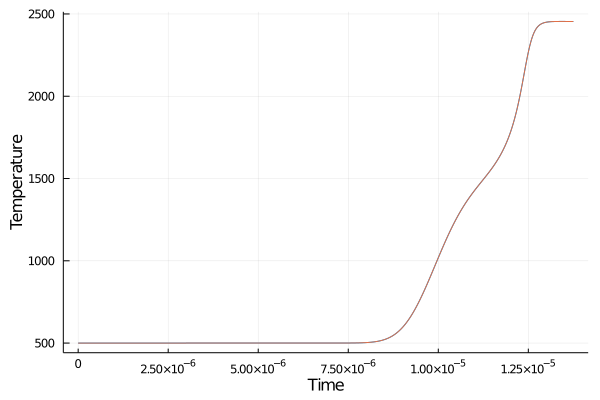

In [99]:
Tt_cant = py"np.load"("data/temperature.npy")
plot(timestep, Tt_cant, label =false)
plot!(timestep, out[:,2], label =false)
xlabel!("Time")
ylabel!("Temperature")

### End of Code

In [11]:
sess = Session()
init(sess)
loss_hist = BFGS!(sess, loss, 250)

2021-02-11 08:28:14.189449: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX
2021-02-11 08:28:14.220056: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2600020000 Hz
2021-02-11 08:28:14.226671: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x258c7970 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-02-11 08:28:14.226763: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-02-11 08:28:14.245374: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/darve/adncat/.conda/envs/my_root/lib/libfabric:/home/darve/adncat/.conda/envs/my_root/lib:/opt/ohpc/pub/compiler/gcc/7.3.0/lib64:/opt/ohpc/p

iter 0, current loss=622382.0144180446
iter 1, current loss=1.0071994209197247e8
iter 2, current loss=851254.7164158834
iter 3, current loss=622291.1923373817
================ STEP 0 ===============
iter 4, current loss=622251.918506644
================ STEP 1 ===============
iter 5, current loss=622022.0743261109
================ STEP 2 ===============
iter 6, current loss=621753.5715526415
================ STEP 3 ===============
iter 7, current loss=620749.1381406822
================ STEP 4 ===============
iter 8, current loss=619595.0481664973
================ STEP 5 ===============
iter 9, current loss=618153.0417921273
================ STEP 6 ===============
iter 10, current loss=616649.8499927453
================ STEP 7 ===============
iter 11, current loss=614873.250930575
================ STEP 8 ===============
iter 12, current loss=614333.8099486578
================ STEP 9 ===============
iter 13, current loss=613454.8861524712
================ STEP 10 ===============
iter 14,

iter 215, current loss=64630.1900216413
================ STEP 185 ===============
iter 216, current loss=65735.25574961591
iter 217, current loss=64036.83878953841
================ STEP 186 ===============
iter 218, current loss=63504.7670924302
================ STEP 187 ===============
iter 219, current loss=63456.73444522815
================ STEP 188 ===============
iter 220, current loss=63390.102459523376
================ STEP 189 ===============
iter 221, current loss=63262.50069241764
================ STEP 190 ===============
iter 222, current loss=63059.2937127667
================ STEP 191 ===============
iter 223, current loss=62625.270562531565
================ STEP 192 ===============
iter 224, current loss=62431.06786060567
================ STEP 193 ===============
iter 225, current loss=62093.48348188538
================ STEP 194 ===============
iter 226, current loss=61698.15263690071
================ STEP 195 ===============
iter 227, current loss=61080.23720064061
======

250-element Array{Any,1}:
 622291.1923373817
 622251.918506644
 622022.0743261109
 621753.5715526415
 620749.1381406822
 619595.0481664973
 618153.0417921273
 616649.8499927453
 614873.250930575
 614333.8099486578
 613454.8861524712
 609042.516533212
 605434.5320365642
      ⋮
  51923.620110997304
  51651.74065714399
  51528.318439545146
  51388.203871068494
  51242.7101299346
  50945.36524550181
  50816.726984504785
  50394.77654131707
  50199.545025208376
  49901.22609264004
  49677.660206506574
  49376.52745860118

In [ ]:
loss_hist2 = BFGS!(sess, loss, 250)

┌ Info: Optimization starts...
└ @ ADCME /home/darve/adncat/.julia/packages/ADCME/OGm7w/src/optim.jl:326


iter 0, current loss=49376.52745860118
iter 1, current loss=5.272624630055369e8
iter 2, current loss=50928.8544397521
iter 3, current loss=49295.270919905124
================ STEP 0 ===============
iter 4, current loss=49230.23010257075
================ STEP 1 ===============
iter 5, current loss=49175.40053051442
iter 6, current loss=49095.48428042537
================ STEP 2 ===============
iter 7, current loss=49004.61557492283
================ STEP 3 ===============
iter 8, current loss=48824.89669691888
================ STEP 4 ===============
iter 9, current loss=48524.56232746484
================ STEP 5 ===============
iter 10, current loss=49730.03368464711
iter 11, current loss=48434.708356091505
================ STEP 6 ===============
iter 12, current loss=48287.48023222658
================ STEP 7 ===============
iter 13, current loss=48221.98374161983
================ STEP 8 ===============
iter 14, current loss=48137.016030228755
================ STEP 9 ===============
iter 1

iter 107, current loss=37101.34661150408
================ STEP 96 ===============
iter 108, current loss=37046.299369506094
================ STEP 97 ===============
iter 109, current loss=36991.43224627777
================ STEP 98 ===============
iter 110, current loss=36883.740933866204
================ STEP 99 ===============
iter 111, current loss=36797.16752760679
================ STEP 100 ===============
iter 112, current loss=36725.239886671116
================ STEP 101 ===============
iter 113, current loss=36620.282106712795
================ STEP 102 ===============
iter 114, current loss=36535.14666816239
================ STEP 103 ===============
iter 115, current loss=36412.04944458642
================ STEP 104 ===============
iter 116, current loss=36311.85248985952
================ STEP 105 ===============
iter 117, current loss=36207.216107366294
================ STEP 106 ===============
iter 118, current loss=36104.276058043644
================ STEP 107 ===============
it

iter 213, current loss=30220.800586095753
================ STEP 188 ===============
iter 214, current loss=30202.23302987354
iter 215, current loss=30154.345308569315
================ STEP 189 ===============
iter 216, current loss=30134.139847866987
================ STEP 190 ===============
iter 217, current loss=30112.77213595225
================ STEP 191 ===============
iter 218, current loss=30091.981606637368
================ STEP 192 ===============
iter 219, current loss=30052.826971462997
================ STEP 193 ===============
iter 220, current loss=30236.715671479054
iter 221, current loss=30044.68552486523
================ STEP 194 ===============
iter 222, current loss=30020.494854564076
================ STEP 195 ===============
iter 223, current loss=30109.394694439725
iter 224, current loss=29991.98006183407
================ STEP 196 ===============
iter 225, current loss=29969.904771655776
================ STEP 197 ===============
iter 226, current loss=29921.145014730

In [ ]:
loss_hist3 = BFGS!(sess, loss, 250)

In [ ]:
loss_hist4 = BFGS!(sess, loss, 250)

In [ ]:
loss_hist5 = BFGS!(sess, loss, 250)

In [13]:
theta_, c_, thetarz_ = run(sess, [θ, C, θrz])

3-element Array{Any,1}:
  [0.30566363094823684, 1.097592436784324, 0.3360416204743442, 0.5779845052184628, 1.6729895096496286, -1.502099732026819, 1.141782745329433, 0.7041683177748694, -1.3321425469771881, -2.293932625042484  …  2.75287274372037, -0.820009168073697, -1.0613011388026778, -1.0459223235470094, 1.0673087450239545, -0.3207669326991842, -1.4733334801118583, 0.732377150196655, 0.21115582389553508, 1.9058374252027113]
 5.912290078750766
  [1.532751201166686, -2.927555596869566, -1.9418655879104858, -0.4848227707877959, -0.6512277628536045, 0.015581250956038737, -0.42976935402407385, -3.236765508085249, -2.0546832146030347, -0.09175386335123598  …  1.1994154505244885, -4.107833687733151, 1.2820096773393903, 1.8335487886874071, -1.0487226194850985, 1.6288152268066876, 1.8790268432209958, -1.9549907167554643, -5.985145236647059, 7.344777850877333]

In [14]:
py"np.save"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/theta_2.npy", theta_)
py"np.save"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/c_2.npy", c_)
py"np.save"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/thetarz_2.npy", thetarz_)

In [10]:
py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/theta_.npy")
py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/c_.npy")
py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/thetarz_.npy")

151-element Array{Float64,1}:
  1.730445985610492
 -2.990674392068383
 -1.9536385393453737
 -0.48535648880928745
 -0.3984866258771475
 -0.12370959888149444
 -0.4300106682329263
 -2.8388738967110125
 -1.8294466998183134
 -0.09522975653310618
 -2.749923570610869
  1.0500505670883993
 -1.118045880449672
  ⋮
  0.16910157448361546
  0.11476708725583076
  0.8397017585225273
 -4.058761815746206
  1.3124738907004727
  1.8717436792801312
 -0.8359277422148464
  1.5849896439237343
  1.837242249084976
 -1.8499395442546382
 -5.943865525425253
  7.390980809339898

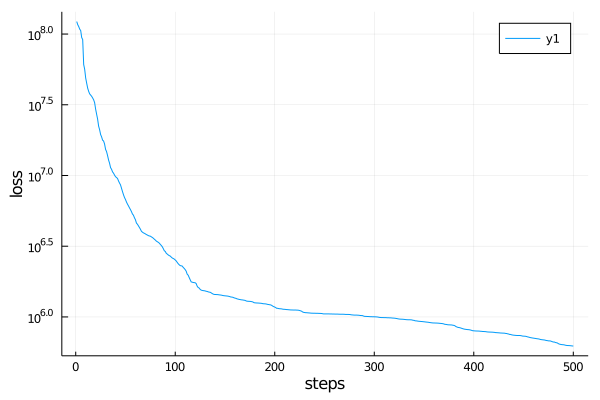

In [18]:
plot([loss_hist; loss_hist2], yaxis =:log)
xlabel!("steps")
ylabel!("loss")

In [11]:
obs = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/obs.npy")

500×50 Array{Float64,2}:
  500.0    500.0    500.0    500.0   …  500.0    500.0     500.0    500.0
  500.0    500.0    500.0    500.0      500.0    500.0     500.0    500.0
  500.0    500.0    500.0    500.0      500.0    500.0     500.0    500.0
  500.0    500.0    500.0    500.0      500.0    500.0     500.0    500.0
  500.0    500.0    500.0    500.0      500.0    500.0     500.0    500.0
  500.0    500.0    500.0    500.0   …  500.0    500.0     500.0    500.0
  500.0    500.0    500.0    500.0      500.0    500.0     500.0    500.0
  500.0    500.0    500.0    500.0      500.0    500.0     500.0    500.0
  500.0    500.0    500.0    500.0      500.0    500.0     500.0    500.0
  500.0    500.0    500.0    500.0      500.0    500.0     500.0    500.0
  500.0    500.0    500.0    500.0   …  500.0    500.0     500.0    500.0
  500.0    500.0    500.0    500.0      500.0    500.0     500.0    500.0
  500.0    500.0    500.0    500.0      500.0    500.0     500.0    500.0
    ⋮        

In [14]:
sess = Session()
init(sess)
frout = run(sess, f_r)

2021-02-22 02:37:52.165001: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX
2021-02-22 02:37:52.195263: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2599995000 Hz
2021-02-22 02:37:52.201832: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xaa0a340 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-02-22 02:37:52.201959: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-02-22 02:37:52.220442: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/darve/adncat/.conda/envs/my_root/lib/libfabric:/home/darve/adncat/.conda/envs/my_root/lib:/opt/ohpc/pub/compiler/gcc/7.3.0/lib64:/opt/ohpc/pu

50×1 Array{Float64,2}:
 0.560951458675936
 0.8790628265907017
 0.44866162416854966
 0.7763023179180729
 0.5162897313676403
 0.37445680179027546
 0.6913688981592758
 0.1831924247656139
 0.19717146638353705
 0.36314678820918184
 0.11441643486268378
 0.6432909666825061
 0.41884368321136506
 ⋮
 0.22024207129992135
 0.6721252506942025
 0.6993950115247423
 0.5767916623606898
 0.8900431219726185
 0.2665825857864103
 0.41750892386518806
 0.6757992503995305
 0.2539489394982284
 0.15075412232830657
 0.6474210899621151
 0.4931834661190973

In [22]:
r = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/r_.npy")
z = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/z_.npy")
#r = range(0, 1, step = 0.25)
#z = range(0, 1, step = 0.25)
#r = reshape(ones(5,1) * r', (5 * 5,1))
#z = reshape(z * ones(5,1)', (5 * 5,1))
r0 = 0.1
z0 = 0.4
fgtrue = (1 .- abs.(r .- r0)) .* (1 .- (z .- z0).^2) 
rx = range(0, 1, step = 0.01)
zx = range(0, 1, step = 0.01)
fx = (1 .- abs.(rx .- r0)) .* (1 .- (zx' .- z0).^2) 
#fx = reshape(fx, (11* 11, 1))
xx = reshape(ones(101,1) * rx', (101 * 101,1))
yy = reshape(zx * ones(101,1)', (101 * 101, 1))
xxx = [xx; r]
yyy = [yy; z]

50×1 Array{Float64,2}:
 0.6065087050554272
 0.9479856139399001
 0.47317291575190784
 0.8269697800246599
 0.5641437969388781
 0.4008825865414418
 0.7305714726161272
 0.2078864031596208
 0.21391818755024528
 0.38118307070771773
 0.12383127342131908
 0.689043335132693
 0.43012985414119287
 ⋮
 0.2190398464469475
 0.7151738116937703
 0.7458278689464942
 0.6049830543766773
 0.8565473189711432
 0.28224185058178203
 0.4287557124548416
 0.7012235188669091
 0.2776053753353302
 0.1761438443093973
 0.691001842369099
 0.5280185081858069

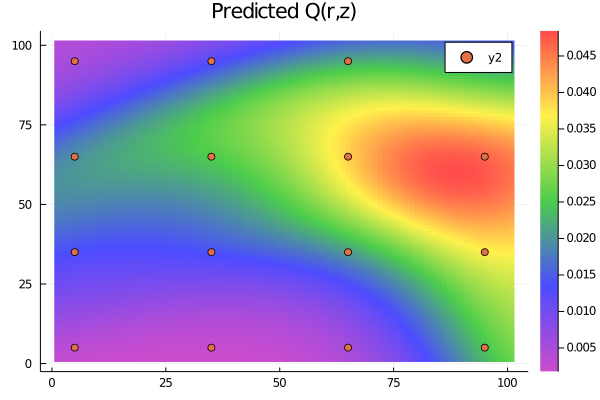

In [72]:
f_var = std(fout_gt, dims = 2)
heatmap(reshape(f_var, (101,101))', title = "Predicted Q(r,z)", c = :lightrainbow)
scatter!(r .* 100, z .* 100)

In [39]:
run(sess, θrz)

151-element Array{Float64,1}:
  1.2603832725603559
  0.8191199802721781
 -0.7701040283231783
  0.7366997906796228
  0.8333014075511332
  0.10651505113471084
 -0.2759144455431692
 -0.3013562687520618
 -1.0368161009380845
 -2.731329673340518
 -1.9538142688947226
  0.32444138129751116
 -0.21379357069640403
  ⋮
  0.022184053346436406
 -1.5442268287904952
 -0.27937942565126256
  1.9251827878894932
 -0.19604606137914674
  1.4339968246215398
  1.4765219422278566
 -1.1119416743749437
 -0.5691739757965237
  0.31570640648110193
 -0.909053716531446
  1.6099638671720333

In [19]:
fpred = fc([xx yy], [10, 10, 1], θrz)
fpred = 1.0 / (1 + exp(-fpred))
fpred_out = run(sess, fpred)

10201×1 Array{Float64,2}:
 0.844806721301493
 0.8504710607177078
 0.8560500112024926
 0.861528826154681
 0.8668929712765706
 0.8721284033185216
 0.8772218365005842
 0.8821609854839793
 0.8869347752681598
 0.8915335104853477
 0.8959489990576839
 0.9001746278482357
 0.9042053905511879
 ⋮
 0.06849339045921042
 0.0679405748173208
 0.0674122156675019
 0.06690865448578935
 0.06643017021595725
 0.0659769831066857
 0.06554925867352211
 0.06514711171841216
 0.06477061034773528
 0.06441977993786273
 0.06409460700505461
 0.06379504294392249

In [50]:
fpred_out

10201×1 Array{Float64,2}:
 0.951533035243699
 0.9524119392063037
 0.9532502748239325
 0.9540490317841405
 0.9548091631602031
 0.9555315834088968
 0.9562171665014124
 0.9568667441716383
 0.9574811042649786
 0.9580609891699787
 0.9586070943142556
 0.959120066705561
 0.9596005034982326
 ⋮
 0.10957771381351325
 0.10843247087888168
 0.10731128394485513
 0.10621729287521278
 0.1051534197361
 0.10412237265478144
 0.10312665147615264
 0.10216855497632328
 0.10125018939462334
 0.1003734780516496
 0.09954017183076323
 0.09875186031311915

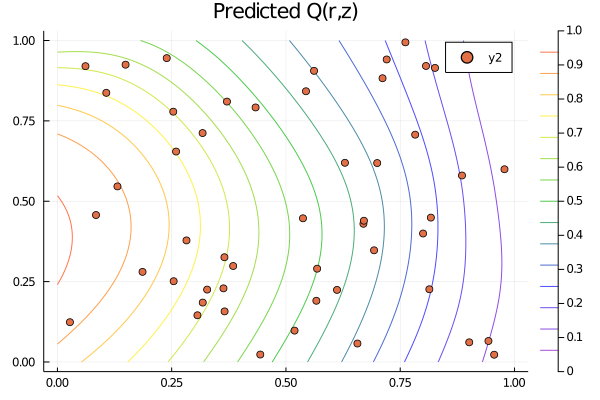

In [35]:
contour(0:0.01:1, 0:0.01:1, reshape(fpred_out, (101,101)), title = "Predicted Q(r,z)", clim = (0, 1), c = :lightrainbow)
scatter!(r, z)

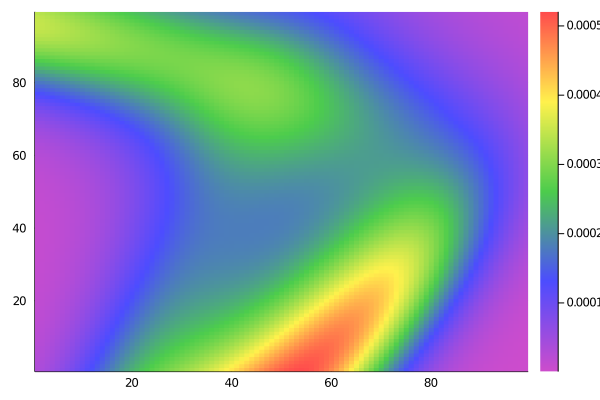

In [82]:
fpd = reshape(fpred_out, (101,101))
mid = fpd[2 : end - 1, 2 : end - 1]
left = fpd[2 : end - 1, 1 : end - 2]
right = fpd[2 : end - 1, 3 : end]
bot = fpd[3 : end, 2 : end - 1]
top = fpd[1 : end - 2, 2 : end - 1]
tv = (left - mid).^2 + (right - mid).^2 + (top - mid).^2 + (bot - mid).^2
heatmap(tv, c = :lightrainbow)

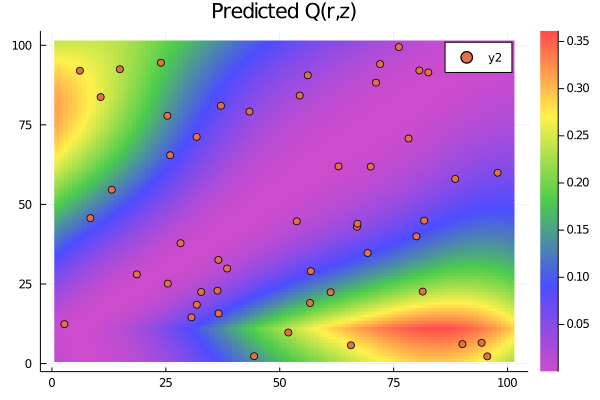

In [53]:
heatmap((fx - reshape(fpred_out, (101,101))).^2, title = "Predicted Q(r,z)", c = :lightrainbow, vmin = 0, vmax = 1)
scatter!(r .* 100, z .* 100)

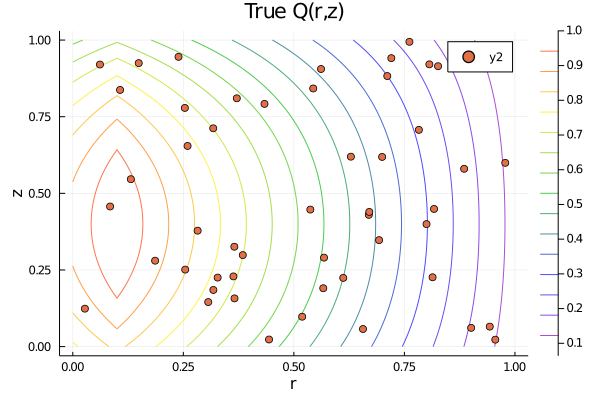

In [51]:
contour(0:0.01:1, 0:0.01:1, fx', xlabel = 'r', ylabel = 'z', title = "True Q(r,z)", c = :lightrainbow)
scatter!(r, z)
#plot!(r, z, frout, st = [:surface])

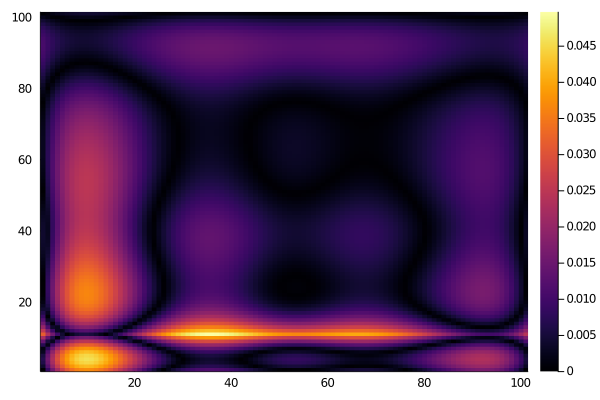

In [175]:
fpred2 = reshape(fpred, (101,101))'

heatmap(abs.(fx - fpred2))

In [30]:
#nt = size(timestep)[1]
k = constant(1, dtype=Int32)
t = constant(timestep)
Us= [TensorArray(nt) for i = 1:num_s]
uout = [constant(nt) for i = 1:num_s]
for i =1:num_s
    Us[i] = write(Us[i], 1, TY)
    _, U_out=while_loop(condition, body, [k, Us[i], t, Qdff[i,:]])
    U_out_i = set_shape(stack(U_out), (nt, N+1))
    uout[i] = U_out_i[:,1]
end

In [31]:
uout_f = run(sess, uout) 

50-element Array{Array{Float64,1},1}:
 [500.0000046801727, 500.00043262587434, 500.0012883726423, 500.0025715591037, 500.0042816073136, 500.00641772302305, 500.0089788960507, 500.01196390075705, 500.01537129662165, 500.01919942892266  …  1521.6905840400093, 1534.9859665507506, 1549.1777682376746, 1564.3672376653074, 1580.6710082571178, 1598.2236237347304, 1617.180297033869, 1637.7197310636334, 1660.0466254320938, 1684.3931255285368]
 [500.0000046801727, 500.0006726565179, 500.0020083821578, 500.00401129000136, 500.0066804731781, 500.01001468546116, 500.0140123418532, 500.0186715193345, 500.0239899577733, 500.02996506099765  …  2455.1299073381183, 2456.606612834472, 2458.168254739572, 2459.816519689803, 2461.5530500314803, 2463.379442075872, 2465.2972443993485, 2467.3079561902005, 2469.4130256435906, 2471.6138484060343]
 [500.0000046801727, 500.00034789767045, 500.0010342170544, 500.0020633494324, 500.00343483276345, 500.005148032072, 500.0072021397442, 500.0095961759065, 500.0123289888

In [21]:
#plot(uout_f[1])
sess = Session()
init(sess)

2021-02-10 19:38:57.340323: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX
2021-02-10 19:38:57.373898: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2600020000 Hz
2021-02-10 19:38:57.379357: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x41ff7490 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-02-10 19:38:57.379458: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-02-10 19:38:57.398582: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/darve/adncat/.conda/envs/my_root/lib/libfabric:/home/darve/adncat/.conda/envs/my_root/lib:/opt/ohpc/pub/compiler/gcc/7.3.0/lib64:/opt/ohpc/p

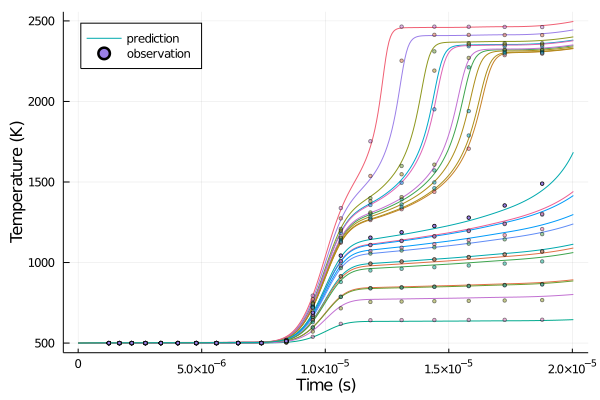

In [66]:
uout_p = zeros(nt, num_s)
for i=1:num_s
   uout_p[:,i] = uout_f[i] 
end
plot(timestep, uout_p[:,20:40], label = false)
plot!(timestep, uout_p[:,1], label = "prediction")
scatter!(timestep[inds], obs[inds, 20:40], alpha=0.5, label = false, markersize = 2)
scatter!(timestep[inds], obs[inds,1], label = "observation", markersize = 2,legend=:topleft)
ylabel!("Temperature (K)")
xlabel!("Time (s)")
#savefig("temperature_rs.pdf")

In [98]:
for i = 1:16
    @info diff[i]
end

┌ Info: 1.981092264217133e8
└ @ Main In[98]:2
┌ Info: 2.118178537468914e7
└ @ Main In[98]:2
┌ Info: 2.632941551676985e8
└ @ Main In[98]:2
┌ Info: 1.730809453006808e7
└ @ Main In[98]:2
┌ Info: 8.050431998393701e7
└ @ Main In[98]:2
┌ Info: 1.531858134439931e8
└ @ Main In[98]:2
┌ Info: 1.1893718064227307e8
└ @ Main In[98]:2
┌ Info: 2.8720430908157233e7
└ @ Main In[98]:2
┌ Info: 1.5446427935997741e7
└ @ Main In[98]:2
┌ Info: 1.5699058694507744e7
└ @ Main In[98]:2
┌ Info: 2.2380406412529075e8
└ @ Main In[98]:2
┌ Info: 2.0272337562476057e8
└ @ Main In[98]:2
┌ Info: 3.5397050743678385e8
└ @ Main In[98]:2
┌ Info: 1.5842799721489968e6
└ @ Main In[98]:2
┌ Info: 6.7605039150536e7
└ @ Main In[98]:2
┌ Info: 15959.812871770895
└ @ Main In[98]:2


In [39]:
diff = sum((uout_p[2:end,:] - obs).^2, dims = 1)

1×50 Array{Float64,2}:
 71156.8  83863.9  30246.5  37188.1  …  8763.73  39457.6  25840.7  15354.2

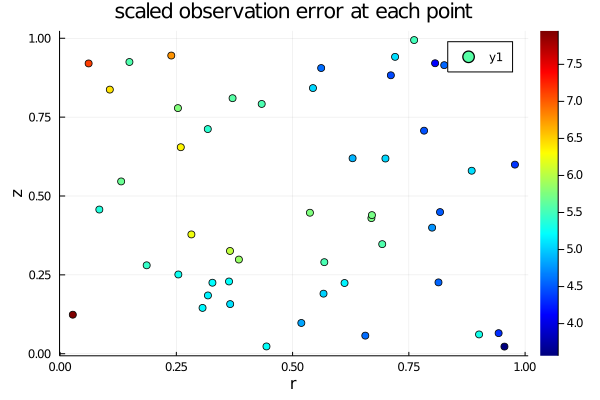

In [60]:
scatter(r,z, marker_z = log.((diff.^(0.5))' .+ 1), title = "scaled observation error at each point", c = :jet)
xlabel!("r")
ylabel!("z")

In [95]:
z

16×1 Array{Float64,2}:
 0.05
 0.35
 0.65
 0.95
 0.05
 0.35
 0.65
 0.95
 0.05
 0.35
 0.65
 0.95
 0.05
 0.35
 0.65
 0.95

In [ ]:
obs = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/obs.npy")
nt = size(timestep)[1]
inds = range(125,nt, step=10)
TY = [T; Y]


function condition(k, U, t)
    k <= nt - 1
end
function body(k, U, t)
    dt = t[k + 1] - t[k]
    uk = read(U,k)
    k1 = f(uk, QQ[k], t[k])
    k2 = f(uk + 0.5 * dt * k1, QQ[k], t[k] + 0.5 * dt)
    k3 = f(uk + 0.5 * dt * k2, QQ[k], t[k] + 0.5 * dt)
    k4 = f(uk + dt * k3, QQ[k], t[k] + dt) 
    u_new = uk + 1/6 * dt * (k1 + 2 * k2 + 2 * k3 + k4)
    U = write(U, k+1, u_new)
    k+1, U, t
end

function compute_solution(QQ, i)
    k = constant(1, dtype=Int32)
    t = constant(timestep)
    U = TensorArray(nt)
    U = write(U, 1, TY)
    _, U_out=while_loop(condition, body, [k, U, t])
    U_array = set_shape(stack(U_out), (nt, N+1))
    return sum((U_array[inds,1]-obs[inds,i])^2)
end

In [ ]:
loss_hist2 = BFGS!(sess, loss, 1000)

In [ ]:
###### nt = size(timestep)[1]
TY = [T; Y]
function condition(k, U, t, θ)
    k <= nt - 1
end

function body(k, U, t, θ)
    dt = t[k + 1] - t[k]
    uk = read(U,k)
    k1 = f(uk, θ)
    k2 = f(uk + 0.5 * dt * k1, θ)
    k3 = f(uk + 0.5 * dt * k2, θ)
    k4 = f(uk + dt * k3, θ) 
    u_new = uk + 1/6 * dt * (k1 + 2 * k2 + 2 * k3 + k4)
    U = write(U, k+1, u_new)
    k+1, U, t, θ
end
k = constant(1, dtype=Int32)
t = constant(timestep)
θ = Variable(pr)
U = TensorArray(nt)
U = write(U, 1, TY)
_, U_out=while_loop(condition, body, [k, U, t, θ])
U_array = set_shape(stack(U_out), (nt, N+1))
sess = Session()
init(sess)
u_out = run(sess, U_array)

In [ ]:
#dt = 1e-6
nt = size(timestep[1:1000])[1]
#### Implicit scheme, need to refine for variable time step and order
function res_and_jac(param, x)
    dt = param[1]
    x0 = param[2:end]
    res = x - x0 - dt * f(x)
    jac = gradients(res, x)
    res, jac 
end

function condition(k, U, t)
    k <= nt - 1
end

function body(k, U, t)
    dt = t[k + 1] - t[k]
    uk = read(U,k)
    ADCME.options.newton_raphson.rtol = 1e-5 # relative tolerance
    ADCME.options.newton_raphson.tol = 1e-5 # absolute tolerance
    ADCME.options.newton_raphson.verbose = true # print details in newton_raphson
    param = tf.concat([tf.reshape(dt, (1,)), uk], 0)
    u_new = newton_raphson_with_grad(res_and_jac, constant(uk), param)
    U = write(U, k+1, u_new)
    k+1, U, t
end

k = constant(1, dtype=Int32)
t = constant(timestep)
U = TensorArray(nt)
U = write(U, 1, TY)
_, U_out=while_loop(condition, body, [k, U, t])
U_array = set_shape(stack(U_out), (nt, N+1))
sess = Session()
init(sess)
u_out = run(sess, U_array)

In [ ]:
#inds = range(1,2000, step=100)
plot(timestep[inds], Y_ref'[inds,:], seriestype = :scatter, legend = false)
plot!(timestep, u_out[:,2:end])
xlabel!("Time")
ylabel!("Mass Fractions")
savefig("Mass_fraction.pdf")

In [ ]:
#inds = range(1,2000, step=400)
plot(timestep[inds], T_ref[inds], seriestype = :scatter, label = "observation")
plot!(timestep[2:end], Tt_cant, label = "true")
plot!(timestep, out[:,1], label = "predicted")
xlabel!("Time")
ylabel!("Temperature")
#savefig("temperature_3.pdf")

In [ ]:
dt = 1e-6
u1 = constant(TY)
function res_and_jac(x0, x)
    res = x - x0 - dt * f(x)
    jac = gradients(res, x)
    res, jac 
end
ADCME.options.newton_raphson.rtol = 1e-4 # relative tolerance
ADCME.options.newton_raphson.tol = 1e-4 # absolute tolerance
ADCME.options.newton_raphson.verbose = true # print details in newton_raphson
u_est = newton_raphson_with_grad(res_and_jac, constant(u1), u1)

In [ ]:
sess = Session()
init(sess)
u_e = run(sess, u_est)

In [ ]:
28.3244  0.0  18.8021
 17.9616  0.0  17.7315

In [ ]:
u_out[range(1,2000, step=100),2:end]

In [ ]:
pr = [log.(Afr) βr log.(Er)]

In [ ]:
loss

In [ ]:
plot(log.(loss), label="log of mse")
xlabel!("steps")
ylabel!("logarithm of loss")
savefig("loss.pdf")

In [ ]:
θ = Variable(fc_init([1,20,20,1]))

In [ ]:
XX = Variable(0.5)
fc(XX, [20,20,1], θ)

In [ ]:
ty = Variable(TY)

In [ ]:
f(ty, θ, constant(0.1))

In [10]:
tout_g = q.(timestep)

501-element Array{Float64,1}:
 3.720075976020783e-32
 3.7319991907266163e-32
 3.7559598109848376e-32
 3.792188033807654e-32
 3.841033733247531e-32
 3.9029720684346613e-32
 3.9786111540893473e-32
 4.0687019660989915e-32
 4.1741507070066417e-32
 4.2960339150409386e-32
 4.4356166674240707e-32
 4.594374306211606e-32
 4.774018205308289e-32
 ⋮
 3.091804808369971e-25
 7.29745526666389e-26
 1.696273788388425e-26
 3.882869943493916e-27
 8.752040123480778e-28
 1.94237210321621e-28
 4.244135946003043e-29
 9.129496855393052e-30
 1.9331787626797394e-30
 4.029318976206412e-31
 8.265945243291972e-32
 1.6688655625551434e-32

In [ ]:
tout = fc(timestep, [20,20,1], θ)
loss = sum((tout - tout_g)^2)

In [ ]:
#θ = Variable(fc_init([1,20,20,1]))
#C = Variable(11.0)
tout = fc(timestep * 1e5, [20,20,1], θ; activation = "tanh")
pred = tout * 10 ^ C
#loss = sum((pred - tout_g)^2) 
#sess = Session()
#init(sess)
#u_out = run(sess, U_array)
#loss_hist = BFGS!(sess, loss)
tout = run(sess, pred)

In [ ]:
#plot(timestep, tout_g)
plot(timestep, tout)

In [15]:
function q(t)
    t0 = 1
    r = 0.1
    c = 1e12
    return c * exp(-(t-t0)^2 / r^2)
end
tout_g = q.(timestep * 1e5)

501-element Array{Float64,1}:
 3.7200759760208887e-32
 3.731999190726828e-32
 3.755959810985051e-32
 3.79218803380787e-32
 3.8410337332476944e-32
 3.9029720684348283e-32
 3.978611154089517e-32
 4.0687019660991656e-32
 4.1741507070068196e-32
 4.2960339150410606e-32
 4.435616667424197e-32
 4.594374306211802e-32
 4.774018205308492e-32
 ⋮
 3.0918048083699275e-25
 7.297455266663994e-26
 1.696273788388401e-26
 3.8828699434938606e-27
 8.752040123480652e-28
 1.94237210321621e-28
 4.244135946002983e-29
 9.129496855393183e-30
 1.9331787626797668e-30
 4.029318976206412e-31
 8.26594524329209e-32
 1.668865562555096e-32

In [72]:
Qdot_out = run(sess, Qdot)

501-element Array{Float64,1}:
 3.578662776533561e9
 3.577990270287355e9
 3.5766452438671427e9
 3.5746276695784783e9
 3.5719375062923193e9
 3.568574699933977e9
 3.564539184141019e9
 3.5598308810839124e9
 3.5544497024478292e9
 3.5483955505830345e9
 3.5416683198127203e9
 3.5342678979104857e9
 3.5261941677341948e9
 ⋮
 3.236687923156454e9
 3.3603343076248803e9
 3.4839798882456517e9
 3.60761828686414e9
 3.731244133131068e9
 3.8548529724646673e9
 3.9784411801545787e9
 4.1020058812726164e9
 4.225544876083854e9
 4.349056570641038e9
 4.47253991228923e9
 4.595994329785683e9

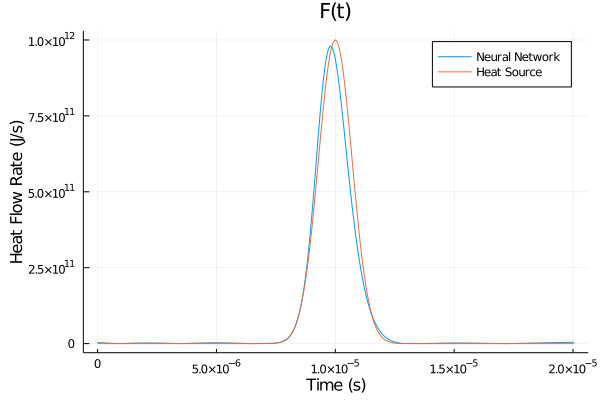

In [117]:
plot(timestep, Qdot_out, label="Neural Network")
plot!(timestep, tout_g, label="Heat Source", title = "F(t)")
xlabel!("Time (s)")
ylabel!("Heat Flow Rate (J/s)")
#savefig("heat_source_rs.pdf")

In [78]:
plot(loss_hist, yaxis=:log, label = "BFGS")
xlabel!("steps")
ylabel!("loss")
savefig("loss_rs.pdf")

In [75]:
maximum(Qdot_out)

9.79433728149519e11

In [10]:
has_mpi()

false